# Setup

In [73]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/w266 project/dontpatronizeme/semeval-2022')
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/w266 project/dontpatronizeme/semeval-2022'

In [74]:
!pip install transformers

In [75]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import random

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import transformers
from transformers import BertTokenizer, TFBertModel, DistilBertTokenizer, TFDistilBertModel

import logging
tf.get_logger().setLevel(logging.ERROR)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [76]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

# Data

In [78]:
from dont_patronize_me import DontPatronizeMe
dpm = DontPatronizeMe('data', 'TEST/task4_test.tsv')
dpm.load_task1()
#dpm.load_task2(return_one_hot=True)
dpm.load_test()

In [79]:
trids = pd.read_csv('practice splits/train_semeval_parids-labels.csv')
teids = pd.read_csv('practice splits/dev_semeval_parids-labels.csv') 
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)
print(trids.shape)
print(teids.shape)

(8375, 2)
(2094, 2)


In [87]:
# Rebuild train set for Task 1
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })

trdf1 = pd.DataFrame(rows)

# Rebuild test set for Task 1
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })

tedf1 = pd.DataFrame(rows)

# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])
training_set1

,par_id,text,label
0,4341,"The scheme saw an estimated 150,000 children f...",1
1,4136,Durban 's homeless communities reconciliation ...,1
2,10352,The next immediate problem that cropped up was...,1
3,8279,Far more important than the implications for t...,1
4,1164,To strengthen child-sensitive social protectio...,1
...,...,...,...
2377,1775,Last but not the least element of culpability ...,0
2378,1776,"Then , taking the art of counter-intuitive non...",0
2379,1777,Kagunga village was reported to lack necessary...,0
2380,1778,"""After her parents high-profile divorce after ...",0


In [88]:
par_ids = []
texts = []
starts = []
finishes = []

with open (os.path.join('data/dontpatronizeme_categories.tsv')) as f:
  for line in f.readlines()[4:]:
    par_id=int(line.strip().split('\t')[0])
    text=line.split('\t')[2]#.lower()
    start=int(line.split('\t')[5])
    finish=int(line.split('\t')[6])

    par_ids.append(par_id)
    texts.append(text)
    starts.append(start)
    finishes.append(finish)

df_text = pd.DataFrame(list(zip(par_ids, texts, starts, finishes)), columns=['par_id', 'text', 'start', 'finish']).sort_values(['par_id', 'start']).drop_duplicates()
print(df_text.shape)
df_text.head()

(2557, 4)


,par_id,text,start,finish
2381,33,Arshad said that besides learning many new asp...,157,243
1232,34,Fast food employee who fed disabled man become...,0,67
2355,42,Vanessa had feelings of hopelessness in her fi...,0,182
868,77,"In September , Major Nottle set off on foot fr...",15,128
869,77,"In September , Major Nottle set off on foot fr...",28,71


In [89]:
span_length = 120
df_text = df_text.loc[(df_text.finish - df_text.start) < span_length]
df_text.shape

(1894, 4)

In [90]:
nopcldf_train = training_set1.loc[training_set1.label==0].iloc[:,[0,1]]
nopcldf_train[['start', 'finish']]=0
nopcldf_test = tedf1.loc[tedf1.label==0].iloc[:,[0,1]]
nopcldf_test[['start', 'finish']]=0
df_text = pd.concat([df_text, nopcldf_train, nopcldf_test])

In [91]:
prev_par_id = df_text.iloc[0, 0]
prev_text = df_text.iloc[0, 1]
cursor = 0

par_ids = []
words = []
tags = []

for _, row in df_text.iterrows():
  par_id=row[0]
  text=row[1]#.lower()
  start=row[2]
  finish=row[3]

  # finish the previous paragraph
  if par_id != prev_par_id:
    words_o = prev_text[cursor:].split()
    for w in words_o:
      par_ids.append(prev_par_id)
      words.append(w)
      tags.append('O')

    # update par_id, text, initialize cursor
    prev_par_id = par_id
    prev_text = text
    cursor = 0

  # add non-PCL words
  if cursor < start:
    words_o = text[cursor:start].split()
    for w in words_o:
      par_ids.append(par_id)
      words.append(w)
      tags.append('O')
    cursor = start

  # add PCL words
  if cursor >= start and cursor <= finish:
    words_bi = text[cursor:finish].split()
    for w in words_bi:
      par_ids.append(par_id)
      words.append(w)
      tags.append('I')
    cursor = finish

words_o = prev_text[cursor:].split()
for w in words_o:
  par_ids.append(prev_par_id)
  words.append(w)
  tags.append('O')
        
df_words = pd.DataFrame(list(zip(par_ids, words, tags)), columns=['par_id', 'word', 'tag'])
#print(df_words.loc[40:60])
#df_words.to_csv('df_words.csv')
df_words

,par_id,word,tag
0,33,Arshad,O
1,33,said,O
2,33,that,O
3,33,besides,O
4,33,learning,O
...,...,...,...
214212,10466,from,O
214213,10466,further,O
214214,10466,NPA,O
214215,10466,exploitation,O


In [92]:
df_words = df_words.astype({'par_id': 'int64'})

df_words_train = df_words[df_words['par_id'].isin([int(par_id) for par_id in trids.par_id])]
df_words_test = df_words[df_words['par_id'].isin([int(par_id) for par_id in teids.par_id])]
print(df_words_train.shape)
print(df_words_train.tag.value_counts())
print(df_words_test.shape)
print(df_words_test.tag.value_counts())

(115762, 3)
O    101521
I     14241
Name: tag, dtype: int64
(98455, 3)
O    94619
I     3836
Name: tag, dtype: int64


In [93]:
print(training_set1.shape)
print(training_set1.label.mean())
print(tedf1.shape)
print(tedf1.label.mean())

(2382, 3)
0.3333333333333333
(2094, 3)
0.09503342884431709


# Bert Model

In [94]:
from transformers import BertTokenizer, TFBertModel

In [95]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [16]:
tokenizer.tokenize('I am 12342 years old.')

['I', 'am', '123', '##42', 'years', 'old', '.']

In [17]:
tokenizer.encode('I am 12342 years old.')

[101, 146, 1821, 13414, 23117, 1201, 1385, 119, 102]

In [18]:
tokenizer.convert_tokens_to_ids(['I', 'am', '123', '##42', 'years', 'old', '.'])

[146, 1821, 13414, 23117, 1201, 1385, 119]

In [19]:
tokenizer.convert_ids_to_tokens([146, 1821, 13414, 23117, 1201, 1385, 119])

['I', 'am', '123', '##42', 'years', 'old', '.']

In [96]:
bert = TFBertModel.from_pretrained('bert-base-cased')
bert.layers
len(bert.layers[0].weights)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


199

In [21]:
input_ids = np.array([tokenizer.encode('I am 12342 years old.')])
bert_output = bert(input_ids)
bert_output[0].shape
bert_output[0]

<tf.Tensor: shape=(1, 9, 768), dtype=float32, numpy=
array([[[ 0.36603326,  0.13595192,  0.18560985, ..., -0.1546022 ,
          0.30067322,  0.02030989],
        [ 0.3904291 , -0.3395814 ,  0.64558804, ..., -0.19691661,
          0.14029945,  0.26259798],
        [-0.18811235, -0.06209275,  0.43153736, ...,  0.06182177,
         -0.1296048 ,  0.24134645],
        ...,
        [-0.18485865, -0.26880467,  0.5040921 , ...,  0.05255371,
          0.55420905,  0.24955851],
        [ 0.19845183,  0.09328808,  0.41547245, ..., -0.08608241,
          0.24223763, -0.16197552],
        [ 0.59372205, -0.01873309,  0.06823754, ..., -0.06672016,
          0.16008201, -0.0414464 ]]], dtype=float32)>

# Input Generation

In [97]:
def addWord(word, tag):
    """
    Convert a word into a word token and add supplied tags. Note that the word can be  
    tokenized to two or more tokens. Correspondingly, we add - for now - custom 'X' tokens to the labels in order to 
    maintain the 1:1 mappings between word tokens and labels.
    
    arguments: word, tag label
    returns: dictionary with tokens and labels
    """
        
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['tagToken'] = [tag] + [tag] * (tokenLength - 1)
    addDict['tokenLength'] = tokenLength
    
    return addDict

addWord('10000', 'O')

{'tagToken': ['O', 'O'], 'tokenLength': 2, 'wordToken': ['1000', '##0']}

In [98]:
max_length = 128

In [145]:
def gen_input(df_words, max_length):

  # lists for par_id, sentences, tokens, labels, etc.  
  parIdList = []
  sentenceList = []
  sentenceTokenList = []
  tagTokenList = []
  sentLengthList = []

  # lists for BERT input
  bertSentenceIDs = []
  bertMasks = []
  bertSequenceIDs = []

  sentence = ''

  # always start with [CLS] tokens
  sentenceTokens = ['[CLS]']
  tagTokens = ['[tagCLS]']

  prev_par_id = -1

  for _, row in df_words.iterrows():

    par_id=row[0]
    word=row[1]
    tag=row[2]

    # if new sentence starts
    if par_id != prev_par_id:

      sentenceLength = min(max_length-1, len(sentenceTokens))
      sentLengthList.append(sentenceLength)

      # create space for a least a final '[SEP]' token
      if sentenceLength >= max_length - 1:
        sentenceTokens = sentenceTokens[:max_length-2]
        tagTokens = tagTokens[:max_length-2]

      # add a [SEP] token and padding
      sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length - 1 - len(sentenceTokens))
      tagTokens += ['[tagSEP]'] + ['[tagPAD]'] * (max_length - 1 - len(tagTokens))

      parIdList.append(prev_par_id)
      sentenceList.append(sentence)
      sentenceTokenList.append(sentenceTokens)

      bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
      bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length - 1 - sentenceLength))
      bertSequenceIDs.append([0] * (max_length))

      tagTokenList.append(tagTokens)

      sentence = ''
      sentenceTokens = ['[CLS]']
      tagTokens = ['[tagCLS]']
      prev_par_id = par_id

      sentence += ' ' + word

    addDict = addWord(word, tag)

    sentenceTokens += addDict['wordToken']
    tagTokens += addDict['tagToken']

  # the first list elements need to be removed. 
  parIdList = parIdList[1:]
  sentLengthList = sentLengthList[1:]
  sentenceTokenList = sentenceTokenList[1:]
  bertSentenceIDs = bertSentenceIDs[1:]
  bertMasks = bertMasks[1:]
  bertSequenceIDs = bertSequenceIDs[1:]
  tagTokenList = tagTokenList[1:]

  return parIdList, sentLengthList, sentenceTokenList, bertSentenceIDs, bertMasks, bertSequenceIDs, tagTokenList


In [100]:
parIdList, sentLengthList, sentenceTokenList, bertSentenceIDs, bertMasks, bertSequenceIDs, tagTokenList = gen_input(df_words, max_length)
# print(sentenceTokenList[1])
# print(tagTokenList[1])
# print(bertMasks[1])
# print(bertSequenceIDs[1])

# Initial Data Analysis

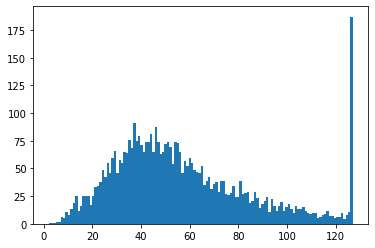

In [101]:
sentenceLengths= [l for l in sentLengthList]
plt.hist(np.array(sentenceLengths), bins=(max_length-2));

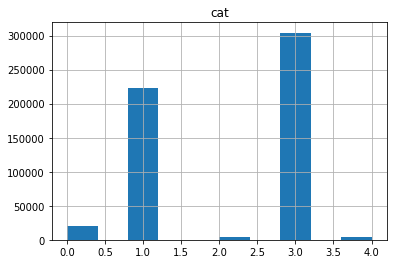

In [102]:
numSentences = len(bertSentenceIDs)

tagClasses = pd.DataFrame(np.array(tagTokenList).reshape(-1))
tagClasses.columns = ['tag']
tagClasses.tag = pd.Categorical(tagClasses.tag)
tagClasses['cat'] = tagClasses.tag.cat.codes
tagClasses['sym'] = tagClasses.tag.cat.codes
tagLabels = np.array(tagClasses.cat).reshape(numSentences, -1) 

tagClasses[['cat']].hist();

In [103]:
tagDistribution = (tagClasses.groupby(['tag', 'cat']).agg({'sym':'count'}).reset_index()
                   .rename(columns={'sym':'occurences'}))

tagClasses = tagDistribution.tag.nunique()

tagDistribution.loc[tagDistribution.occurences>0]

,tag,cat,occurences
0,I,0,20167
6,O,1,223516
12,[tagCLS],2,4348
18,[tagPAD],3,304165
24,[tagSEP],4,4348


# Final Data Prep

In [29]:
#bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])

In [104]:
trainPar_ids, _, _, trainSentence_ids, trainMasks, trainSequence_ids, tagClasses_train = gen_input(df_words_train, max_length)
testPar_ids, _, _, testSentence_ids, testMasks, testSequence_ids, tagClasses_test = gen_input(df_words_test, max_length)

X_train = np.array([trainSentence_ids,trainMasks,trainSequence_ids])
X_test = np.array([testSentence_ids,testMasks,testSequence_ids])

In [105]:
l = ['I', 'O', '[tagCLS]', '[tagPAD]', '[tagSEP]']
d = dict([(y,x) for x,y in enumerate(sorted(set(l)))])
print(d)

tagLabels_train = np.array([[d[y] for y in x] for x in tagClasses_train])
tagLabels_test = np.array([[d[y] for y in x] for x in tagClasses_test])

{'I': 0, 'O': 1, '[tagCLS]': 2, '[tagPAD]': 3, '[tagSEP]': 4}


In [106]:
clsLabels_train = np.array([training_set1.loc[training_set1.par_id == str(i)]['label'].values[0] for i in trainPar_ids])
clsLabels_test = np.array([tedf1.loc[tedf1.par_id == str(i)]['label'].values[0] for i in testPar_ids])

In [107]:
# Use a parameter pair k_start, k_end to look at slices. This helps with quick tests.

k_start = 0
k_end = -1

if k_end == -1:
    k_end_train = X_train[0].shape[0]
    k_end_test = X_test[0].shape[0]
else:
    k_end_train = k_end_test = k_end
    
bert_inputs_train_k = [X_train[0][k_start:k_end_train], X_train[1][k_start:k_end_train], 
                       X_train[2][k_start:k_end_train]]
bert_inputs_test_k = [X_test[0][k_start:k_end_test], X_test[1][k_start:k_end_test], 
                      X_test[2][k_start:k_end_test]]

labels_train_k = tagLabels_train[k_start:k_end_train]
labels_test_k = tagLabels_test[k_start:k_end_test]

cls_labels_train_k = clsLabels_train[k_start:k_end_train]
cls_labels_test_k = clsLabels_test[k_start:k_end_test]

In [108]:
train_all = [bert_inputs_train_k, labels_train_k, cls_labels_train_k]
test_all = [bert_inputs_test_k, labels_test_k, cls_labels_test_k]

In [170]:
# 2382
print(len(trainPar_ids))
print(np.mean(cls_labels_train_k))
print(bert_inputs_train_k[0].shape)

2271
0.3011889035667107
(2271, 128)


In [171]:
# 2049
print(len(testPar_ids))
print(np.mean(cls_labels_test_k))
print(bert_inputs_test_k[0].shape)

2076
0.08815028901734104
(2076, 128)


In [168]:
np.intersect1d(np.array(trainPar_ids).astype('int'), np.array(testPar_ids).astype('int'))

array([], dtype=int64)

# Basic BERT Classifier

In [109]:
from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Flatten

from tensorflow.keras.utils import set_random_seed
set_random_seed(1)

In [110]:
bert_inputs_train_k

[array([[  101,   138,  1733, ...,     0,     0,     0],
        [  101, 13227,  2094, ...,     0,     0,     0],
        [  101,  1130,  1347, ...,     0,     0,     0],
        ...,
        [  101,  1599,   117, ...,     0,     0,     0],
        [  101, 14812, 11652, ...,     0,     0,     0],
        [  101,   107,  1258, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [111]:
try:
    del classification_model
except:
    pass

try:
    del bert_model
except:
    pass

tf.keras.backend.clear_session()

# parameter
hidden_size = 256
train_layers = -1
optimizer = tf.keras.optimizers.Adam(5e-5)
#optimizer = tf.keras.optimizers.Adam(lr=5e-5, beta_1=0.91, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)


# model & layers
bert_model = TFBertModel.from_pretrained('bert-base-cased')
dense_layer = tf.keras.layers.Dense(hidden_size, name='hidden_layer')
cls_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [112]:
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids_layer')
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')

bert_inputs = {'input_ids': input_ids,
              'token_type_ids': token_type_ids,
              'attention_mask': attention_mask}

#restrict training to the train_layers outer transformer layers
if not train_layers == -1:

        retrain_layers = []

        for retrain_layer_number in range(train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                w._trainable = False


bert_out = bert_model(bert_inputs) #, output_hidden_states=True

classification_token = tf.keras.layers.Lambda(lambda x: x[:,0,:], name='get_first_vector')(bert_out[0])
dense = dense_layer(classification_token)
dense = tf.keras.layers.Dropout(rate=0.1)(dense)
classification = cls_layer(dense)

classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], 
                                      outputs=[classification])

classification_model.compile(optimizer=optimizer,
                        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                        metrics='accuracy')

In [113]:
for epoch in range(2):
  classification_model.fit(bert_inputs_train_k, cls_labels_train_k,
                           epochs=1, batch_size=32)
  
  y_predict_values = classification_model.predict(bert_inputs_test_k, 
                                          batch_size=32, verbose=1)  
  

  print('Validation')
  print('AUC:', roc_auc_score(cls_labels_test_k, y_predict_values))
  
  for threshold in [0.5, 0.7, 0.9, 0.99, 0.999]:
    y_predict = [1 if i[0]>threshold else 0 for i in y_predict_values]
    print('Threshold:', threshold, 
          '| Precision:', np.round(precision_m(cls_labels_test_k, y_predict).numpy(),4),
          '| Recall:', np.round(recall_m(cls_labels_test_k, y_predict).numpy(),4),
          '| F1:', np.round(f1_score(cls_labels_test_k, y_predict),4))

65/65 [==============================] - 20s 274ms/step
Validation
AUC: 0.9198571671877119
Threshold: 0.5 | Precision: 0.4864 | Recall: 0.6831 | F1: 0.5682
Threshold: 0.7 | Precision: 0.7281 | Recall: 0.4536 | F1: 0.5589
Threshold: 0.9 | Precision: 0.9524 | Recall: 0.2186 | F1: 0.3556
Threshold: 0.99 | Precision: 0.0 | Recall: 0.0 | F1: 0.0
Threshold: 0.999 | Precision: 0.0 | Recall: 0.0 | F1: 0.0
65/65 [==============================] - 18s 273ms/step
Validation
AUC: 0.9293832035771711
Threshold: 0.5 | Precision: 0.5292 | Recall: 0.694 | F1: 0.6005
Threshold: 0.7 | Precision: 0.677 | Recall: 0.5956 | F1: 0.6337
Threshold: 0.9 | Precision: 0.8298 | Recall: 0.4262 | F1: 0.5632
Threshold: 0.99 | Precision: 0.9608 | Recall: 0.2678 | F1: 0.4188
Threshold: 0.999 | Precision: 1.0 | Recall: 0.2295 | F1: 0.3733


# The Model

In [64]:
from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Flatten

from tensorflow.keras.utils import set_random_seed
set_random_seed(1)

In [65]:
numTagClasses = 5
weights = [0.8, 0.2, 0.0]

def custom_loss_weighted(y_true, y_pred):
    """
    calculate loss function explicitly, filtering out 'extra inserted labels'
    
    y_true: Shape: (batch x (max_length + 1) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns:  cost
    """

    #get labels and predictions: 0 -> I
    y_label = tf.reshape(Flatten()(tf.cast(y_true, tf.int32)),[-1])
    mask = (y_label == 0)   # This mask is used to remove all tokens that do not correspond to the original base text.
    y_label_masked_0 = tf.boolean_mask(y_label, mask)  # mask the labels
    y_flat_pred = tf.reshape(Flatten()(tf.cast(y_pred, tf.float32)),[-1, numTagClasses])
    y_flat_pred_masked_0 = tf.boolean_mask(y_flat_pred, mask) # mask the predictions

    #get labels and predictions: 1 -> O
    y_label = tf.reshape(Flatten()(tf.cast(y_true, tf.int32)),[-1])
    mask = (y_label == 1)   # This mask is used to remove all tokens that do not correspond to the original base text.
    y_label_masked_1 = tf.boolean_mask(y_label, mask)  # mask the labels
    y_flat_pred = tf.reshape(Flatten()(tf.cast(y_pred, tf.float32)),[-1, numTagClasses])
    y_flat_pred_masked_1 = tf.boolean_mask(y_flat_pred, mask) # mask the predictions

    #3 -> tagPAD
    y_label = tf.reshape(Flatten()(tf.cast(y_true, tf.int32)),[-1])
    mask = (y_label == 3)   # This mask is used to remove all tokens that do not correspond to the original base text.
    y_label_masked_2 = tf.boolean_mask(y_label, mask)  # mask the labels
    y_flat_pred = tf.reshape(Flatten()(tf.cast(y_pred, tf.float32)),[-1, numTagClasses])
    y_flat_pred_masked_2 = tf.boolean_mask(y_flat_pred, mask) # mask the predictions

    weighted_loss = tf.reduce_mean(sparse_categorical_crossentropy(y_label_masked_0, y_flat_pred_masked_0,from_logits=False)) * weights[0] +\
                    tf.reduce_mean(sparse_categorical_crossentropy(y_label_masked_1, y_flat_pred_masked_1,from_logits=False)) * weights[1] +\
                    tf.reduce_mean(sparse_categorical_crossentropy(y_label_masked_2, y_flat_pred_masked_2,from_logits=False)) * weights[2] 

    return weighted_loss

In [66]:
def custom_acc_orig_tokens(y_true, y_pred):
    """
    calculate loss dfunction filtering out also the newly inserted labels
    
    y_true: Shape: (batch x (max_length) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns: accuracy
    """

    #get labels and predictions
    
    y_label = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])
    
    mask = (y_label < 2)
    y_label_masked = tf.boolean_mask(y_label, mask)
    
    y_predicted = tf.math.argmax(input = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_pred, tf.float64)),\
                                                    [-1, numTagClasses]), axis=1)
    
    y_predicted_masked = tf.boolean_mask(y_predicted, mask)

    return tf.reduce_mean(tf.cast(tf.equal(y_predicted_masked,y_label_masked) , dtype=tf.float64))

In [67]:
def recall_m(y_true, y_pred):
  y_true = tf.cast(y_true, 'float32')
  y_pred = tf.reshape(tf.cast(y_pred, 'float32'), [-1])
  TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = TP / (Positives+K.epsilon())    
  return recall 
    
def precision_m(y_true, y_pred):
  y_true = tf.cast(y_true, 'float32')
  y_pred = tf.reshape(tf.cast(y_pred, 'float32'), [-1])
  TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))   
  precision = TP / (Pred_Positives+K.epsilon())
  return precision

def custom_f1(y_true, y_pred):     
  precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [68]:
#adam_customized = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.91, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)
adam_default = tf.keras.optimizers.Adam(5e-5)

In [69]:
tf.keras.backend.clear_session()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

bert_layer = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [70]:
max_input_length = max_length + 1
train_layers = -1
optimizer = adam_default

in_id = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="input_ids")
in_mask = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="input_masks")
in_segment = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="segment_ids")
bert_inputs = [in_id, in_mask, in_segment]

# Note: Bert layer from Hugging Face returns two values: sequence ouput, and pooled output. Here, we only want
# the former. (See https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel) 

# Freeze layers, i.e. only train number of layers specified, starting from the top
if not train_layers == -1:
    retrain_layers = []
    for retrain_layer_number in range(train_layers):
        layer_code = '_' + str(11 - retrain_layer_number)
        retrain_layers.append(layer_code)
    for w in bert_layer.weights:
        if not any([x in w.name for x in retrain_layers]):
            w._trainable = False
# End of freezing section

bert_sequence = bert_layer(bert_inputs)[0]

# dual task: span detection
dense_span = tf.keras.layers.Dense(256, activation='relu', name='dense')(bert_sequence)
dense_span = tf.keras.layers.Dropout(rate=0.1)(dense_span)
pred_span = tf.keras.layers.Dense(5, activation='softmax', name='tag')(dense_span)

# main task: classification
dense_layer = tf.keras.layers.Dense(256, name='hidden_layer')
cls_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='cls')

classification_token = tf.keras.layers.Lambda(lambda x: x[:,0,:], name='get_first_vector')(bert_sequence)
dense_cls = dense_layer(classification_token)
dense_cls = tf.keras.layers.Dropout(rate=0.1)(dense_cls)
pred_cls = cls_layer(dense_cls)

## Prepare for multipe loss functions, although not used here
losses = {"tag": custom_loss_weighted, 
          "cls": tf.keras.losses.BinaryCrossentropy(from_logits=False)}
#lossWeights = {"tag": 0.3,
#               "cls": 0.7}
lossWeights = {"tag": 0.0,
               "cls": 1.0}               
metrics = {"tag": custom_acc_orig_tokens}
           #"cls": custom_f1}

model = tf.keras.models.Model(inputs=bert_inputs, outputs=[pred_span, pred_cls])
model.compile(loss=losses, optimizer=optimizer, loss_weights=lossWeights, metrics=metrics) 

In [71]:
for epoch in range(2):

  model.fit(
      bert_inputs_train_k, 
      {"tag": labels_train_k, "cls": cls_labels_train_k},
      validation_data=(bert_inputs_test_k, {"tag": labels_test_k, "cls": cls_labels_test_k}),
      epochs=1,
      batch_size=32)

  # train
  result = model.predict(
    bert_inputs_train_k, 
    batch_size=32)
  
  print('Train')
  print('AUC:', roc_auc_score(cls_labels_train_k, result[1]))
  print('Precision:', precision_m(cls_labels_train_k, result[1]).numpy(),
        'Recall:', recall_m(cls_labels_train_k, result[1]).numpy(),
        'F1:',custom_f1(cls_labels_train_k, result[1]).numpy())

  # validation
  result = model.predict(
    bert_inputs_test_k, 
    batch_size=32)
  
  print('Validation')
  print('AUC:', roc_auc_score(cls_labels_test_k, result[1]))
  print('Precision:', precision_m(cls_labels_test_k, result[1]).numpy(),
        'Recall:', recall_m(cls_labels_test_k, result[1]).numpy(),
        'F1:',custom_f1(cls_labels_test_k, result[1]).numpy())
  
  for threshold in [0.5, 0.7, 0.9, 0.99, 0.999]:
    y_predict = [1 if i[0]>threshold else 0 for i in result[1]]
    print('Threshold:', threshold, '| F1:', f1_score(cls_labels_test_k, y_predict))

47/47 [==============================] - 111s 1s/step - loss: 0.5299 - tag_loss: 1.7612 - cls_loss: 0.5299 - tag_custom_acc_orig_tokens: 0.1188 - val_loss: 0.5135 - val_tag_loss: nan - val_cls_loss: 0.5135 - val_tag_custom_acc_orig_tokens: 0.1065
Train
AUC: 0.9794971350191367
Precision: 0.8443038 Recall: 0.9751462 F1: 0.9050203
Validation
AUC: 0.9215458736385705
Precision: 0.2359882 Recall: 0.87431693 F1: 0.37166083
Threshold: 0.5 | F1: 0.3716608594657375
Threshold: 0.7 | F1: 0.4931506849315068
Threshold: 0.9 | F1: 0.6158536585365854
Threshold: 0.99 | F1: 0.43589743589743585
Threshold: 0.999 | F1: 0.19704433497536947
47/47 [==============================] - 55s 1s/step - loss: 0.2426 - tag_loss: 1.8774 - cls_loss: 0.2426 - tag_custom_acc_orig_tokens: 0.1013 - val_loss: 0.2760 - val_tag_loss: nan - val_cls_loss: 0.2760 - val_tag_custom_acc_orig_tokens: 0.0479
Train
AUC: 0.9977305074371512
Precision: 0.9824047 Recall: 0.9795322 F1: 0.98096627
Validation
AUC: 0.9257055761953011
Precision:

In [72]:
predictions_flat = [pred for preds in np.argmax(result[0], axis=2) for pred in preds]
labels_flat = [label for labels in tagLabels_test for label in labels]

clean_preds = []
clean_labels = []

for pred, label in zip(predictions_flat, labels_flat):
    if label < 2:
        clean_preds.append(pred)
        clean_labels.append(label)

cm = tf.math.confusion_matrix(
    clean_labels,
    clean_preds,
    num_classes=None,
    dtype=tf.dtypes.int32,
    name=None,
    weights=None
)

cm

<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[  345,   406,   656,  1252,  1633],
       [27926,  5119, 10182, 12008, 53362],
       [    0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0]], dtype=int32)>

# IG

In [58]:
y_predict_values = result[1]
y_test = cls_labels_test_k

# baseline
baseline = tf.zeros(shape=(1, max_length, 768))

# example
par_id = 4046
i = testPar_ids.index(par_id)
print('pred:', y_predict_values[i][0], 'truth', y_test[i])
#text_ig = [bert_inputs_test_k[0][i:(i+1)], bert_inputs_test_k[1][i:(i+1)], bert_inputs_test_k[2][i:(i+1)]]
text_ig = {'input_ids': bert_inputs_test_k[0][i:(i+1)],
           'token_type_ids': bert_inputs_test_k[1][i:(i+1)],
           'attention_mask': bert_inputs_test_k[2][i:(i+1)]}

# get embeddings
embedding = bert_layer(text_ig, output_hidden_states=True)[2][0] # hidden_states / 1st layer # checked that it's correct.
#idx_sep = np.where(text_ig.input_ids[0]==102)[0][0]
#embedding = embedding[:,1:idx_sep,:]

# for output
tokenized_words = tokenizer.convert_ids_to_tokens(text_ig['input_ids'][0]) # for output

" ".join(tokenized_words)

pred: 0.98450124 truth 1


'[CLS] We also know that they can benefit by receiving counseling from someone who can help them understand that their feelings are normal and that their situation is not hopeless ; someone who can help them put their situation in perspective and help them communicate with others who could provide support ; someone knowledge ##able about resources they can access ; someone who can help them plan for their needs and the needs of their child by developing either a parent ##ing plan or an adoption plan . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [59]:
# create model from classification model that takes embeddings
input_embeds = tf.keras.layers.Input(shape=(max_length, 768), dtype=tf.float32, name='input_embeds_layer')
token_type_ids_ig = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids_layer')
attention_mask_ig = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')

bert_inputs_ig = {'inputs_embeds': input_embeds,
                  'token_type_ids': token_type_ids_ig,
                  'attention_mask': attention_mask_ig}

bert_out_ig = bert_layer(bert_inputs_ig) #output_hidden_states=True

classification_token_ig = tf.keras.layers.Lambda(lambda x: x[:,0,:], name='get_first_vector')(bert_out_ig[0])
dense_ig = dense_layer(classification_token_ig)
dense_ig = tf.keras.layers.Dropout(rate=0.1)(dense_ig)
classification_ig = cls_layer(dense_ig)

classification_model_ig = tf.keras.Model(inputs=[input_embeds, token_type_ids_ig, attention_mask_ig], 
                                         outputs=[classification_ig])

classification_model_ig.predict([embedding, text_ig['token_type_ids'], text_ig['attention_mask']])

array([[0.9432987]], dtype=float32)

In [60]:
m_steps = 20
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

def interpolate_embeddings(baseline, embedding, alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(embedding, axis=0)
  delta = input_x - baseline_x
  embeddings = baseline_x +  alphas_x * delta
  return embeddings

interpolated_embeddings = interpolate_embeddings(baseline, embedding, alphas)
interpolated_embeddings.shape

TensorShape([21, 1, 128, 768])

In [61]:
def compute_gradients(embeddings, text_ig):
  with tf.GradientTape() as tape:
    tape.watch(embeddings)
    probs = classification_model_ig([tf.squeeze(embeddings, axis=1),
                                     tf.repeat(text_ig['token_type_ids'], embeddings.shape[0], axis=0),
                                     tf.repeat(text_ig['attention_mask'], embeddings.shape[0], axis=0)])
  return tape.gradient(probs, embeddings)

path_gradients = compute_gradients(interpolated_embeddings, text_ig)
path_gradients.shape

TensorShape([21, 1, 128, 768])

In [62]:
def integral_approximation(gradients):
  integrated_gradients = tf.math.reduce_mean(gradients, axis=[0,3])
  return integrated_gradients

attrs = integral_approximation(path_gradients)
attrs.shape

TensorShape([1, 128])

In [63]:
from IPython.display import HTML
import matplotlib as mpl

# Return HTML markup which highlights the text with a desired color.
def  hlstr(string, color='white'):
    return f"<mark style=background-color:{color}>{string} </mark>"

# Calculates color based on attribution values
def colorize(attrs, cmap='PiYG'):
    cmap_bound = np.abs(attrs).max()
    norm = mpl.colors.Normalize(vmin=-cmap_bound, vmax=cmap_bound)
    cmap = mpl.cm.get_cmap(cmap)

    colors = list(map(lambda x: mpl.colors.rgb2hex(cmap(norm(x))), attrs))
    return colors

colors = colorize(attrs[0])
HTML("".join(list(map(hlstr, tokenized_words, colors))))

# Evaluation

In [52]:
# output
labels2file([[y] for y in y_predict], os.path.join('res/task1.txt'))

# Evaluate
!python3 evaluation.py . .
!cat scores.txt

Traceback (most recent call last):
  File "evaluation.py", line 35, in <module>
    t1p = precision_score(task1_gold, task1_res)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1765, in precision_score
    zero_division=zero_division,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1544, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1348, in _check_set_wise_labels
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 84, in _check_targets
    check_consistent_length(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 334, in check_consistent_length
    % [int(l) for l in lengths]
ValueError: Found input variable

In [121]:
df_text_s = dpm.test_set_df.loc[:,['par_id', 'text']]
df_text_s[['start', 'finish']]=0
df_text_s

,par_id,text,start,finish
0,t_0,"In the meantime , conservatives are working to...",0,0
1,t_1,In most poor households with no education chil...,0,0
2,t_2,The real question is not whether immigration i...,0,0
3,t_3,"In total , the country 's immigrant population...",0,0
4,t_4,"Members of the church , which is part of Ken C...",0,0
...,...,...,...,...
3827,t_3893,In a letter dated Thursday to European Commiss...,0,0
3828,t_3894,They discovered that poor families with health...,0,0
3829,t_3895,"She married at 19 , to Milan ( Emil ) Badovina...",0,0
3830,t_3896,The United Kingdom is n't going to devolve int...,0,0


In [123]:
prev_par_id = df_text_s.iloc[0, 0]
prev_text = df_text_s.iloc[0, 1]
cursor = 0

par_ids = []
words = []
tags = []

for _, row in df_text_s.iterrows():
  par_id=row[0]
  text=row[1]#.lower()
  start=row[2]
  finish=row[3]

  # finish the previous paragraph
  if par_id != prev_par_id:
    words_o = prev_text[cursor:].split()
    for w in words_o:
      par_ids.append(prev_par_id)
      words.append(w)
      tags.append('O')

    # update par_id, text, initialize cursor
    prev_par_id = par_id
    prev_text = text
    cursor = 0

  # add non-PCL words
  if cursor < start:
    words_o = text[cursor:start].split()
    for w in words_o:
      par_ids.append(par_id)
      words.append(w)
      tags.append('O')
    cursor = start

  # add PCL words
  if cursor >= start and cursor <= finish:
    words_bi = text[cursor:finish].split()
    for w in words_bi:
      par_ids.append(par_id)
      words.append(w)
      tags.append('I')
    cursor = finish

words_o = prev_text[cursor:].split()
for w in words_o:
  par_ids.append(prev_par_id)
  words.append(w)
  tags.append('O')
        
df_words_s = pd.DataFrame(list(zip(par_ids, words, tags)), columns=['par_id', 'word', 'tag'])
#print(df_words.loc[40:60])
#df_words.to_csv('df_words.csv')
df_words_s

,par_id,word,tag
0,t_0,In,O
1,t_0,the,O
2,t_0,meantime,O
3,t_0,",",O
4,t_0,conservatives,O
...,...,...,...
185313,t_3897,their,O
185314,t_3897,clandestine,O
185315,t_3897,illicit,O
185316,t_3897,spigot,O


In [146]:
submitPar_ids, _, _, submitSentence_ids, submitMasks, submitSequence_ids, tagClasses_submit = gen_input(df_words_s, max_length)

In [147]:
np.array(submitPar_ids)

array(['t_0', 't_1', 't_2', ..., 't_3894', 't_3895', 't_3896'],
      dtype='<U6')

In [148]:
len(submitPar_ids)

3831

In [149]:
X_submit = [np.array(submitSentence_ids), np.array(submitMasks), np.array(submitSequence_ids)]
X_submit

[array([[ 101, 1130, 1103, ...,    0,    0,    0],
        [ 101, 1130, 1211, ...,    0,    0,    0],
        [ 101, 1109, 1842, ...,    0,    0,    0],
        ...,
        [ 101, 1220, 2751, ...,    0,    0,    0],
        [ 101, 1153, 1597, ...,    0,    0,    0],
        [ 101, 1109, 1244, ..., 1114,  102,    0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [157]:
# Task 1
y_predict_values = classification_model.predict(X_submit, batch_size=32, verbose=1)  
  
y_predict = [1 if i[0]>0.5 else 0 for i in y_predict_values]
y_predict.append(0)

# output
labels2file([[y] for y in y_predict], os.path.join('res/task1.txt'))

120/120 [==============================] - 33s 276ms/step


In [158]:
# load test data
# predict & output (task1 with model, task2 with random)

os.chdir('res')

!cat task1.txt | head -n 3
!cat task2.txt | head -n 3
!zip submission.zip task1.txt task2.txt

os.chdir('..')
#os.chdir('/content/drive/MyDrive/w266 project/dontpatronizeme/semeval-2022')

0
1
0
0,1,0,1,0,1,1
1,1,0,1,0,0,0
1,0,0,0,0,0,0
updating: task1.txt (deflated 94%)
updating: task2.txt (deflated 87%)


In [159]:
np.mean(np.array(y_predict))

0.09498956158663883

In [ ]:
# threshold 0.7
#task1_precision:0.55023923445
#task1_recall:0.362776025237
#task1_f1:0.437262357414

# threshold 0.5
#task1_precision:0.403846153846
#task1_recall:0.463722397476
#task1_f1:0.431718061674

# there must be something wrong with the f1 score calculated in this notebook, achieving 0.6+
# maybe the f1 score, but seems unlikely b/c it's also used in other notebooks
# or something wrong with train / test data leakage, but checked and seems fine.
# could it be sorting of data somehow affecting it? 
# or some other weird reason?
# create a cleaner spreadsheet.
# the challenge really lies with I & O tags for words broken into multiple tokens
# 